# Spatial joins and plotting in Python and geopandas

In [1]:
import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt, matplotlib.cm as cm
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
%matplotlib inline

## Load the rental listings and TAZ polygons

In [2]:
# load the shapefile of TAZs
taz = gpd.read_file('data/TAZ/bayarea_superdistricts.shp')

In [3]:
# load rental listings point data
df = pd.read_csv('data/rents.csv')
geom = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
rentals = gpd.GeoDataFrame(df, geometry=geom)

In [4]:
# how many rows do we have in each data set?
print(len(taz))
print(len(rentals))

34
1399


In [5]:
rentals['geometry'].head()

0    POINT (-122.254525 37.833301)
1    POINT (-122.299779 37.534536)
2    POINT (-121.587796 37.015489)
3    POINT (-121.950268 37.310883)
4        POINT (-122.8315 39.1194)
Name: geometry, dtype: object

Looks like the geometry we loaded is in lat-long. So, set the CRS of this geodataframe to lat-long, so that it knows what coordinate system this is initially.

In [6]:
original_crs = {'init':'epsg:4326'}
rentals.crs = original_crs

## Project the data so it's all in the same CRS

In [7]:
print(rentals.crs)
print(taz.crs)

{'init': 'epsg:4326'}
{'init': 'epsg:26910'}


The initial CRSs of these two data sets are not the same, because the saved data we loaded was in lat-long and UTM, respectively. We have two data sets: one point data set of rental listings, in lat-long, and one polygon data set of TAZs, in UTM-10. To work with these two data sets together, they need to be in the same CRS, so we need to project one. We'll project the rental listings from lat-long to the TAZs' UTM CRS.

In [8]:
rentals = rentals.to_crs(taz.crs)

In [9]:
print(rentals.crs)
print(taz.crs)

{'init': 'epsg:26910'}
{'init': 'epsg:26910'}


Ok, now they're the same. To confirm, we can scatter plot the points over the polygons and make sure everything lines up.

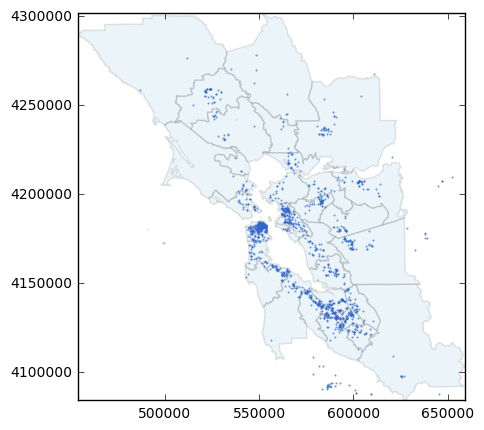

In [10]:
fig, ax = plt.subplots(figsize=(5,5))

# extract each polygon as a descartes patch, and add to a matplotlib patch collection...
patches = []
for geometry in taz['geometry']:
    if isinstance(geometry, Polygon):
        patches.append(PolygonPatch(geometry))
    elif isinstance(geometry, MultiPolygon):
        for subpolygon in geometry: #if geometry is multipolygon, go through each constituent subpolygon
            patches.append(PolygonPatch(subpolygon))
pc = PatchCollection(patches, facecolor='#3399cc', linewidth=1, alpha=0.1)
ax.add_collection(pc)

# extract coordinates into separate numpy arrays and scatter plot
xy = rentals['geometry'].map(lambda point: point.xy)
x, y = zip(*xy)
ax.scatter(x=x, y=y, s=2, color='#3366cc', linewidth=0, alpha=0.7)

# set the figure bounds to the polygons' bounds
left, bottom, right, top = taz.total_bounds
ax.set_xlim((left,right))
ax.set_ylim((bottom,top))
plt.show()

## Spatial join rental listings to TAZs

In [11]:
# doubly confirm their CRSs match before doing the spatial join
rentals.crs==taz.crs

True

In [12]:
# get the taz district for each rental listing, with spatial join
# use op='within' to use rtree spatial index for much faster operation
taz_rentals = gpd.sjoin(rentals, taz, how='left', op='within')
len(taz_rentals)

1399

In [13]:
# optionally drop all the listings outside of any TAZ, then convert the TAZ IDs to int
taz_rentals = taz_rentals.dropna(subset=['SUPERD'])
taz_rentals['SUPERD'] = taz_rentals['SUPERD'].astype(int)
len(taz_rentals)

1347

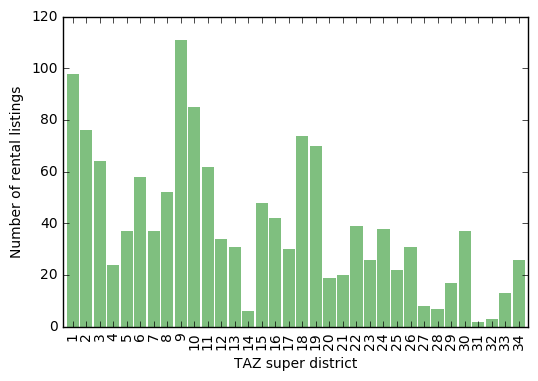

In [14]:
# how many rental listings are in each taz?
ax = taz_rentals['SUPERD'].value_counts().sort_index().plot(kind='bar',
                                                            width=0.9,
                                                            color='g',
                                                            alpha=0.5,
                                                            linewidth=0)
ax.set_xlabel('TAZ super district')
ax.set_ylabel('Number of rental listings')
plt.show()

## Plot each rental listing colored according to TAZ

In [15]:
# get a color for each taz
color_list = [cm.get_cmap('plasma')(x) for x in np.linspace(0, 1, len(taz['SUPERD']))]
taz_colors = {taz+1:color for taz, color in enumerate(color_list)}
colors = taz_rentals['SUPERD'].map(lambda x: taz_colors[x])

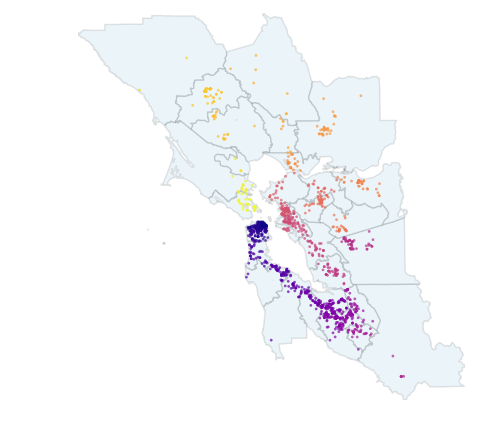

In [16]:
fig, ax = plt.subplots(figsize=(5,5))

# extract each polygon as a descartes patch, and add to a matplotlib patch collection...
patches = []
for geometry in taz['geometry']:
    if isinstance(geometry, Polygon):
        patches.append(PolygonPatch(geometry))
    elif isinstance(geometry, MultiPolygon):
        for subpolygon in geometry: #if geometry is multipolygon, go through each constituent subpolygon
            patches.append(PolygonPatch(subpolygon))
pc = PatchCollection(patches, facecolor='#3399cc', linewidth=1, alpha=0.1)
ax.add_collection(pc)

# extract coordinates into separate numpy arrays and scatter plot
xy = taz_rentals['geometry'].map(lambda point: point.xy)
x, y = zip(*xy)
ax.scatter(x=x, y=y, s=4, color=colors, linewidth=0, alpha=0.7)

# set the figure bounds to the polygons' bounds
left, bottom, right, top = taz.total_bounds
ax.set_xlim((left,right))
ax.set_ylim((bottom,top))
ax.axis('off')
plt.show()

Points are colored by TAZ, but you could color them by any other attribute, such as distance to job center or whatnot

## Color polygons by number of rental listings per acre

...or by median rent, etc.

In [17]:
# count the number of listings in each TAZ then merge the counts with the TAZ geodataframe
counts = pd.DataFrame(taz_rentals['SUPERD'].value_counts()).reset_index().rename(columns={'index':'SUPERD',
                                                                                          'SUPERD':'count_listings'})
taz_counts = pd.merge(taz, counts, how='left', on='SUPERD')

In [18]:
# calculate the number of listings per acre in each TAZ, then sort by it
taz_counts['listings_acre'] = taz_counts['count_listings'] / taz_counts['LANDACRE']
taz_counts = taz_counts.sort_values(by='listings_acre')

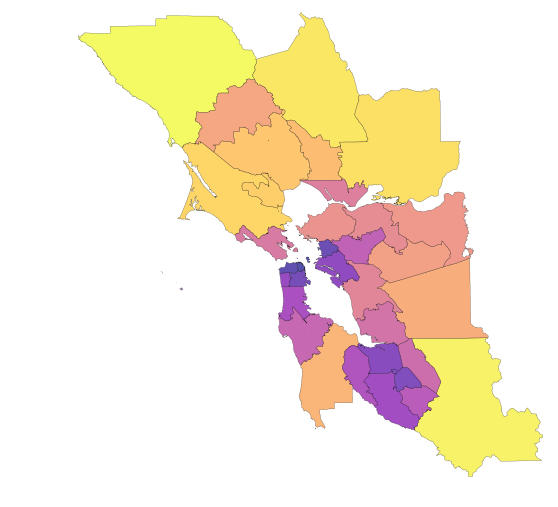

In [19]:
fig, ax = plt.subplots(figsize=(6,6))

# extract each polygon as a descartes patch, and add to a matplotlib patch collection...
patches = []
fc = []
for geometry, color in zip(taz_counts['geometry'], reversed(color_list)):
    if isinstance(geometry, Polygon):
        patches.append(PolygonPatch(geometry))
        fc.append(color)
    elif isinstance(geometry, MultiPolygon):
        for subpolygon in geometry: #if geometry is multipolygon, go through each constituent subpolygon
            patches.append(PolygonPatch(subpolygon))
            fc.append(color)
pc = PatchCollection(patches, facecolor=fc, linewidth=0.2, alpha=0.7)
ax.add_collection(pc)

# set the figure bounds to the polygons' bounds
left, bottom, right, top = taz_counts.total_bounds
ax.set_xlim((left,right))
ax.set_ylim((bottom,top))
ax.axis('off')
plt.show()